# Spike Plotting

Brief 1-2 sentence description of notebook.

In [1]:
import glob
import re
import os

In [2]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Inputs & Data

Explanation of each input and where it comes from.

In [3]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case

TRIAL_LENGTH = 10
SAMPLING_RATE = 20000
TONE_TIMESTAMP_DF = pd.read_excel("../../rce_tone_timestamp.xlsx", index_col=0)
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs

INPUT_DIR=glob.glob("/scratch/back_up/reward_competition_extention/proc/phy_curation/*")

In [4]:
TRIAL_NUMBER_COL = "trial_number"

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [5]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names

def calc_bmi(weight, height):
    """
    This is a function that calculates BMI.
    it uses height and weight...etc.
    Meghan plz show us your docsctring format here.
    """
    bmi = weight/(height**2)
    return(bmi)


In [6]:
def find_closest(target, reference_list):
    """
    Finds the closest number in a reference list to the given target number.

    Parameters:
    - target (float or int): The number for which we want to find the closest value.
    - reference_list (list of float or int): The list of numbers in which we want to search.

    Returns:
    - float or int: The closest number from the reference list to the target.
    """

    # Using the 'min' function with a custom key to determine the closest value by minimal absolute difference
    closest_value = min(reference_list, key=lambda x: abs(x - target))
    
    return closest_value

In [7]:
def find_index_in_group(group, value_column, new_column_name):
    unique_values = sorted(list(set(group[value_column])))
    group[new_column_name] = group[value_column].apply(lambda x: unique_values.index(x) + 1)
    return group

### Getting the subject IDs from the file name

- Dropping all unlabeled trials

In [8]:
all_trials_df = TONE_TIMESTAMP_DF.dropna(subset="condition").sort_values(by=["recording_file", "time_stamp_index"]).reset_index(drop=True)

- Making sure that all timestamps are integers

In [9]:
all_trials_df["time"] = all_trials_df["time"].astype(int)
all_trials_df["time_stamp_index"] = all_trials_df["time_stamp_index"].astype(int)
all_trials_df["video_frame"] = all_trials_df["video_frame"].astype(int)

In [10]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,condition,competition_closeness,Unnamed: 13
0,6310663,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,NaN,NaN
1,7910662,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,NaN,NaN
2,9710660,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,NaN,NaN
3,11310658,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,NaN,NaN
4,12810657,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,NaN,NaN


- Original timestamps are based on ephys recordings at 20kHz. The LFP will be at 1kHz, so we will need to divide all the timestamps by 20

In [11]:
all_trials_df["resampled_index"] = all_trials_df["time_stamp_index"] // 20

In [12]:
all_trials_df["recording_dir"].unique()

array(['20221202_134600_omission_and_competition_subject_6_1_and_6_2',
       '20221203_154800_omission_and_competition_subject_6_4_and_6_1',
       '20221214_125409_om_and_comp_6_1_and_6_3',
       '20221215_145401_comp_amd_om_6_1_and_6_3',
       '20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2',
       '20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-2_and_1-4',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_and_1-2'],
      dtype=object)

- Getting a list of all the subjects through the recording name

In [13]:
all_trials_df["all_subjects"] = all_trials_df["recording_dir"].apply(lambda x: ["{}.{}".format(tup[0],tup[1]) for tup in re.findall(r'(\d+)-(\d+)', x.replace("_", "-"))[1:]])

In [14]:
all_trials_df["all_subjects"].head()

0    [6.1, 6.2]
1    [6.1, 6.2]
2    [6.1, 6.2]
3    [6.1, 6.2]
4    [6.1, 6.2]
Name: all_subjects, dtype: object

- Getting the current subject of the recording through the ending of the recording name file

In [15]:
all_trials_df["subject_info"].head()

0    6_1_top_2_base_3
1    6_1_top_2_base_3
2    6_1_top_2_base_3
3    6_1_top_2_base_3
4    6_1_top_2_base_3
Name: subject_info, dtype: object

In [16]:
all_trials_df["current_subject"] = all_trials_df["subject_info"].apply(lambda x: ".".join(x.replace("-","_").split("_")[:2]))

In [17]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,condition,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject
0,6310663,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,69541,"[6.1, 6.2]",6.1
1,7910662,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,149541,"[6.1, 6.2]",6.1
2,9710660,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,239541,"[6.1, 6.2]",6.1
3,11310658,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,NaN,NaN,319541,"[6.1, 6.2]",6.1
4,12810657,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,394541,"[6.1, 6.2]",6.1


- Labeling the trial as a winner or loser if the winner matches the subject id or not

In [18]:
all_trials_df["trial_outcome"] = all_trials_df.apply(
    lambda x: "win" if str(x["condition"]).strip() == str(x["current_subject"]) 
             else ("lose" if str(x["condition"]) in x["all_subjects"] 
                   else x["condition"]), axis=1)

In [19]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,condition,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject,trial_outcome
0,6310663,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,69541,"[6.1, 6.2]",6.1,rewarded
1,7910662,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,149541,"[6.1, 6.2]",6.1,rewarded
2,9710660,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,239541,"[6.1, 6.2]",6.1,rewarded
3,11310658,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,NaN,NaN,319541,"[6.1, 6.2]",6.1,omission
4,12810657,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,394541,"[6.1, 6.2]",6.1,rewarded


# Reading in Phy

- Reading in a spreadsheet of all the unit classifications
    - They are divided up into good units, multi-units, and noise

In [20]:
INPUT_DIR

['/scratch/back_up/reward_competition_extention/proc/phy_curation/tbc',
 '/scratch/back_up/reward_competition_extention/proc/phy_curation/20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged.rec',
 '/scratch/back_up/reward_competition_extention/proc/phy_curation/20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged.rec',
 '/scratch/back_up/reward_competition_extention/proc/phy_curation/20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged.rec']

In [21]:
recording_to_cluster_info = {}
for recording_dir in INPUT_DIR:
    try:
        recording_basename = os.path.basename(recording_dir).strip(".rec")
        file_path = os.path.join(recording_dir, "phy", "cluster_info.tsv")
        recording_to_cluster_info[recording_basename] = pd.read_csv(file_path, sep="\t")
    except Exception as e:
        print(e)

[Errno 2] No such file or directory: '/scratch/back_up/reward_competition_extention/proc/phy_curation/tbc/phy/cluster_info.tsv'


In [22]:
recording_to_cluster_info[list(recording_to_cluster_info.keys())[0]]

,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id
0,2,0,0,0,24.692951,1,0.0,20.0,1.070175,good,3658,0,3.0
1,3,235,106,472,10.347874,1,0.0,20.0,14.493880,mua,49542,0,4.0
2,4,64,25,149,11.953332,4,0.0,80.0,27.163371,mua,92848,0,5.0
3,10,69,29,194,10.297276,18,0.0,360.0,6.455279,mua,22065,0,12.0
4,11,619,261,1295,9.638424,19,0.0,380.0,18.195901,mua,62196,0,13.0
5,17,65,37,141,10.680766,24,0.0,480.0,6.339427,mua,21669,0,19.0
6,18,3,0,21,13.899227,24,0.0,480.0,3.850641,mua,13162,0,20.0
7,20,0,0,0,19.467382,11,0.0,220.0,0.739585,good,2528,0,7.0
8,21,0,0,0,19.467382,11,0.0,220.0,0.078698,mua,269,0,7.0
9,22,0,0,0,21.967876,13,0.0,260.0,0.465459,good,1591,0,8.0


- Combining all the unit info dataframes and adding the recording name

In [23]:
recording_to_cluster_info_df = pd.concat(recording_to_cluster_info, names=['recording_name']).reset_index(level=1, drop=True).reset_index()


In [24]:
recording_to_cluster_info_df.head()

,recording_name,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id
0,20230620_114347_standard_comp_to_omission_D4_s...,2,0,0,0,24.692951,1,0.0,20.0,1.070175,good,3658,0,3.0
1,20230620_114347_standard_comp_to_omission_D4_s...,3,235,106,472,10.347874,1,0.0,20.0,14.493880,mua,49542,0,4.0
2,20230620_114347_standard_comp_to_omission_D4_s...,4,64,25,149,11.953332,4,0.0,80.0,27.163371,mua,92848,0,5.0
3,20230620_114347_standard_comp_to_omission_D4_s...,10,69,29,194,10.297276,18,0.0,360.0,6.455279,mua,22065,0,12.0
4,20230620_114347_standard_comp_to_omission_D4_s...,11,619,261,1295,9.638424,19,0.0,380.0,18.195901,mua,62196,0,13.0


- Filtering for the good units

In [25]:
good_unit_cluster_info_df = recording_to_cluster_info_df[recording_to_cluster_info_df["group"] == "good"].reset_index(drop=True)

In [26]:
good_unit_cluster_info_df.head()

,recording_name,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id
0,20230620_114347_standard_comp_to_omission_D4_s...,2,0,0,0,24.692951,1,0.0,20.0,1.070175,good,3658,0,3.0
1,20230620_114347_standard_comp_to_omission_D4_s...,20,0,0,0,19.467382,11,0.0,220.0,0.739585,good,2528,0,7.0
2,20230620_114347_standard_comp_to_omission_D4_s...,22,0,0,0,21.967876,13,0.0,260.0,0.465459,good,1591,0,8.0
3,20230620_114347_standard_comp_to_omission_D4_s...,34,0,0,0,23.960157,22,0.0,440.0,0.402266,good,1375,0,17.0
4,20230620_114347_standard_comp_to_omission_D4_s...,57,2,0,7,22.906088,0,NaN,0.0,2.406577,good,8226,0,NaN


In [27]:
recording_to_good_unit_ids = good_unit_cluster_info_df.groupby('recording_name')['cluster_id'].apply(list).to_dict()


- A list of all the unit IDs that each spike came from in order
    - First item is first spike, second item is second spike, etc.

In [28]:
recording_to_spike_clusters = {}
for recording_dir in INPUT_DIR:
    try:
        recording_basename = os.path.basename(recording_dir).strip(".rec")
        file_path = os.path.join(recording_dir, "phy", "spike_clusters.npy")
        recording_to_spike_clusters[recording_basename] = np.load(file_path)
    except Exception as e:
        print(e)

[Errno 2] No such file or directory: '/scratch/back_up/reward_competition_extention/proc/phy_curation/tbc/phy/spike_clusters.npy'


In [29]:
recording_to_spike_clusters[list(recording_to_spike_clusters.keys())[0]]

array([ 4,  4, 11, ...,  4,  4, 87], dtype=int32)

In [30]:
recording_to_spike_clusters[list(recording_to_spike_clusters.keys())[0]].shape

(487318,)

- The times that all the spikes happened

In [31]:
recording_to_spike_times = {}
for recording_dir in INPUT_DIR:
    try:
        recording_basename = os.path.basename(recording_dir).strip(".rec")
        file_path = os.path.join(recording_dir, "phy", "spike_times.npy")
        recording_to_spike_times[recording_basename] = np.load(file_path)
    except Exception as e:
        print(e)

[Errno 2] No such file or directory: '/scratch/back_up/reward_competition_extention/proc/phy_curation/tbc/phy/spike_times.npy'


In [32]:
recording_to_spike_times[list(recording_to_spike_times.keys())[0]]

array([[     160],
       [     483],
       [     503],
       ...,
       [68361973],
       [68362204],
       [68362381]])

In [33]:
recording_to_spike_times[list(recording_to_spike_times.keys())[0]].shape

(487318, 1)

### Combining everything into a dataframe

In [34]:
recording_to_spike_df = {}
for recording_dir in INPUT_DIR:
    try:
        recording_basename = os.path.basename(recording_dir).strip(".rec")
        cluster_info_path = os.path.join(recording_dir, "phy", "cluster_info.tsv")
        cluster_info_df = pd.read_csv(cluster_info_path, sep="\t")

        spike_clusters_path = os.path.join(recording_dir, "phy", "spike_clusters.npy")
        spike_clusters = np.load(spike_clusters_path)
        
        spike_times_path = os.path.join(recording_dir, "phy", "spike_times.npy")
        spike_times = np.load(spike_times_path)

        spike_df = pd.DataFrame({'spike_clusters': spike_clusters, 'spike_times': spike_times.T[0]})

        merged_df = spike_df.merge(cluster_info_df, left_on='spike_clusters', right_on='cluster_id', how="left")
        merged_df["recording_name"] = recording_basename

        merged_df["timestamp_isi"] = merged_df.groupby('spike_clusters')["spike_times"].diff()
        merged_df["current_isi"] = merged_df["timestamp_isi"] / SAMPLING_RATE
        
        if not merged_df.empty:
            recording_to_spike_df[recording_basename] = merged_df
       
    except Exception as e:
        print(e)

[Errno 2] No such file or directory: '/scratch/back_up/reward_competition_extention/proc/phy_curation/tbc/phy/cluster_info.tsv'


- Combining the spike time df for all recordings

In [35]:
all_spike_time_df = pd.concat(recording_to_spike_df.values())

In [36]:
all_spike_time_df = all_spike_time_df[all_spike_time_df["group"] == "good"].reset_index(drop=True)

In [37]:
all_spike_time_df.head()

,spike_clusters,spike_times,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id,recording_name,timestamp_isi,current_isi
0,89,535,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,NaN,NaN
1,89,1047,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,512.0,0.02560
2,89,1384,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,337.0,0.01685
3,89,1585,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,201.0,0.01005
4,89,1793,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,208.0,0.01040


In [38]:
all_spike_time_df.tail()

,spike_clusters,spike_times,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id,recording_name,timestamp_isi,current_isi
622770,146,38957244,146,0,0,0,14.943707,6,0.0,120.0,0.695852,good,1433,0,18.0,20230619_115321_standard_comp_to_omission_D3_s...,173.0,0.00865
622771,146,38957331,146,0,0,0,14.943707,6,0.0,120.0,0.695852,good,1433,0,18.0,20230619_115321_standard_comp_to_omission_D3_s...,87.0,0.00435
622772,204,38957511,204,1,0,1,11.366614,6,0.0,120.0,8.020020,good,16516,0,17.0,20230619_115321_standard_comp_to_omission_D3_s...,3072.0,0.15360
622773,44,38957537,44,3,1,29,9.739503,17,0.0,340.0,13.732511,good,28280,0,46.0,20230619_115321_standard_comp_to_omission_D3_s...,2342.0,0.11710
622774,134,38957868,134,5,4,17,8.562255,2,0.0,40.0,14.537135,good,29937,0,11.0,20230619_115321_standard_comp_to_omission_D3_s...,1151.0,0.05755


# Merging the trial information

- Adding a column that is the trial number

In [39]:


# Apply the function to each group and create the new column
all_trials_df = all_trials_df.groupby(["recording_file"]).apply(lambda x: find_index_in_group(x, "time", TRIAL_NUMBER_COL)).reset_index(drop="True")



In [40]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,condition,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject,trial_outcome,trial_number
0,6310663,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,69541,"[6.1, 6.2]",6.1,rewarded,1
1,7910662,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,149541,"[6.1, 6.2]",6.1,rewarded,2
2,9710660,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,239541,"[6.1, 6.2]",6.1,rewarded,3
3,11310658,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,NaN,NaN,319541,"[6.1, 6.2]",6.1,omission,4
4,12810657,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,394541,"[6.1, 6.2]",6.1,rewarded,5


In [41]:
all_trials_df.tail()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,condition,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject,trial_outcome,trial_number
698,32281440,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,29088396,20230621_111240_standard_comp_to_omission_D5_s...,29033,2.0,1-4_t3b3L_box1,1.2,Subj 1 then Subj 2,NaN,1454419,"[1.4, 1.2]",1.4,lose,18
699,34481464,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,31288420,20230621_111240_standard_comp_to_omission_D5_s...,31230,1.0,1-4_t3b3L_box1,1.2,Subj 1 then Subj 2,NaN,1564421,"[1.4, 1.2]",1.4,lose,19
700,34481464,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,31288420,20230621_111240_standard_comp_to_omission_D5_s...,31230,2.0,1-4_t3b3L_box1,1.2,Subj 1 then Subj 2,NaN,1564421,"[1.4, 1.2]",1.4,lose,19
701,35681479,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,32488435,20230621_111240_standard_comp_to_omission_D5_s...,32428,1.0,1-4_t3b3L_box1,1.2,Subj 1 then Subj 2,NaN,1624421,"[1.4, 1.2]",1.4,lose,20
702,35681479,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,32488435,20230621_111240_standard_comp_to_omission_D5_s...,32427,2.0,1-4_t3b3L_box1,1.2,Subj 1 then Subj 2,NaN,1624421,"[1.4, 1.2]",1.4,lose,20


- Creating 10 ms time bins for each trial

In [42]:
all_trials_df["trial_chunked_ephys_timestamp"] = all_trials_df["time"].apply(lambda x: [int(x +  SAMPLING_RATE * num * 0.1) for num in range(-100,101)])

In [43]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,condition,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject,trial_outcome,trial_number,trial_chunked_ephys_timestamp
0,6310663,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,69541,"[6.1, 6.2]",6.1,rewarded,1,"[6110663, 6112663, 6114663, 6116663, 6118663, ..."
1,7910662,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,149541,"[6.1, 6.2]",6.1,rewarded,2,"[7710662, 7712662, 7714662, 7716662, 7718662, ..."
2,9710660,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,239541,"[6.1, 6.2]",6.1,rewarded,3,"[9510660, 9512660, 9514660, 9516660, 9518660, ..."
3,11310658,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,NaN,NaN,319541,"[6.1, 6.2]",6.1,omission,4,"[11110658, 11112658, 11114658, 11116658, 11118..."
4,12810657,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,394541,"[6.1, 6.2]",6.1,rewarded,5,"[12610657, 12612657, 12614657, 12616657, 12618..."


- Getting the closest trial number for each spike

In [44]:
# Getting a list of all the trials for each recording
recording_to_trials = {}
# Loop through each unique key
for key in all_trials_df['recording_file'].unique():
    # Filter the DataFrame based on the key and get the 'Value' column as a list
    recording_to_trials[key] = all_trials_df[all_trials_df['recording_file'] == key]['time'].tolist()


In [45]:
recording_to_trials[list(recording_to_trials.keys())[0]]

[6310663,
 7910662,
 9710660,
 11310658,
 12810657,
 14810655,
 16710653,
 18510652,
 20110658,
 21910649,
 23910646,
 25710642,
 28110642,
 29910641,
 35869034,
 37469033,
 39269032,
 40869030,
 42369029,
 44369024,
 46269025,
 48069023,
 49669022,
 51469020,
 53469018,
 55269017,
 57669012,
 59469010,
 61169008,
 62969007,
 64869008,
 67269005,
 68869004]

In [46]:
# Calculating the timestamp of the closest tone onset for each spike 
all_spike_time_df["closest_trial"] = all_spike_time_df.apply(lambda row: find_closest(row["spike_times"], recording_to_trials[row["recording_name"]]), axis=1)

- Filtering out all spikes that are now within a 10 second range of the tone

In [47]:
all_spike_time_df = all_spike_time_df[(all_spike_time_df["spike_times"] > all_spike_time_df["closest_trial"] - 10 * SAMPLING_RATE) & (all_spike_time_df["spike_times"] < all_spike_time_df["closest_trial"] + 10 * SAMPLING_RATE)]

- Classifying each spike as being before or after the trial

In [48]:
all_spike_time_df["trial_or_baseline"] = all_spike_time_df.apply(lambda row: "trial" if row["spike_times"] >= row["closest_trial"] else "baseline", axis=1)

In [49]:
all_spike_time_df.head()

,spike_clusters,spike_times,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id,recording_name,timestamp_isi,current_isi,closest_trial,trial_or_baseline
18173,89,8060750,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,2973.0,0.14865,8260195,baseline
18174,89,8061199,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,449.0,0.02245,8260195,baseline
18175,89,8061583,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,384.0,0.01920,8260195,baseline
18176,89,8061753,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,170.0,0.00850,8260195,baseline
18177,89,8062027,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,274.0,0.01370,8260195,baseline


- Removing duplicate columns

In [50]:
all_trials_df = all_trials_df.drop_duplicates(subset=["recording_file", "time"], keep="first").reset_index()

- Merging the trial and spike timestamp dataframe based on shared recording and trial timestamp

In [51]:
merged_spike_trial_df = pd.merge(left=all_spike_time_df, right=all_trials_df, left_on=["recording_name", "closest_trial"], right_on=["recording_file", "time"], how="inner")

In [52]:
merged_spike_trial_df["timestamp_bin"] = merged_spike_trial_df.apply(lambda row: np.digitize(row["spike_times"], row["trial_chunked_ephys_timestamp"]) - 101, axis=1)

In [53]:
merged_spike_trial_df.head()

,spike_clusters,spike_times,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,...,condition,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject,trial_outcome,trial_number,trial_chunked_ephys_timestamp,timestamp_bin
0,89,8060750,89,11,11,13,17.238409,26,0.0,520.0,...,1.2,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[8060195, 8062195, 8064195, 8066195, 8068195, ...",-100
1,89,8061199,89,11,11,13,17.238409,26,0.0,520.0,...,1.2,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[8060195, 8062195, 8064195, 8066195, 8068195, ...",-100
2,89,8061583,89,11,11,13,17.238409,26,0.0,520.0,...,1.2,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[8060195, 8062195, 8064195, 8066195, 8068195, ...",-100
3,89,8061753,89,11,11,13,17.238409,26,0.0,520.0,...,1.2,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[8060195, 8062195, 8064195, 8066195, 8068195, ...",-100
4,89,8062027,89,11,11,13,17.238409,26,0.0,520.0,...,1.2,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[8060195, 8062195, 8064195, 8066195, 8068195, ...",-100


In [54]:
merged_spike_trial_df["timestamp_bin"].max()

99

In [55]:
merged_spike_trial_df["relative_time_to_tone"] = merged_spike_trial_df["spike_times"] - merged_spike_trial_df["closest_trial"]

In [56]:
merged_spike_trial_df["relative_time_to_tone"]

0        -199445
1        -198996
2        -198612
3        -198442
4        -198168
           ...  
129045    137534
129046    137621
129047    137801
129048    137827
129049    138158
Name: relative_time_to_tone, Length: 129050, dtype: int64

In [57]:
merged_spike_trial_df["recording_file"].unique()[0] 

'20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged'

In [58]:
from collections import defaultdict

In [59]:
total_number_of_trials_dict = all_trials_df.groupby(["recording_file", "trial_outcome"]).count()["index"].to_dict()

In [60]:
total_number_of_trials_dict

{('20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged',
  'omission'): 3,
 ('20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged',
  'rewarded'): 11,
 ('20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged',
  'win'): 19,
 ('20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged',
  'lose'): 2,
 ('20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged',
  'omission'): 3,
 ('20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged',
  'rewarded'): 11,
 ('20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged',
  'win'): 17,
 ('20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3', 'lose'): 6,
 ('20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3', 'omission'): 3,
 ('20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3', 'rewarded'): 11,
 ('20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3', 'win'): 13,
 ('20221215_145401_comp_amd_om_6_1_top_4_base_3', 'om

In [61]:
grouped_df = merged_spike_trial_df.groupby(["recording_file", "trial_number", "spike_clusters", "trial_outcome"])['relative_time_to_tone'].agg(list).reset_index()

# Rename the aggregated column

In [62]:
grouped_df["total_number_of_trials"] = grouped_df.apply(lambda row: total_number_of_trials_dict[(row["recording_file"], row["trial_outcome"])], axis=1)

In [63]:
grouped_df

,recording_file,trial_number,spike_clusters,trial_outcome,relative_time_to_tone,total_number_of_trials
0,20230619_115321_standard_comp_to_omission_D3_s...,1,11,win,"[-186280, -184483, -180311, -158280, -134277, ...",5
1,20230619_115321_standard_comp_to_omission_D3_s...,1,28,win,"[-83746, -45168, -40065, 67498, 163241]",5
2,20230619_115321_standard_comp_to_omission_D3_s...,1,44,win,"[-197425, -196008, -194460, -194311, -193794, ...",5
3,20230619_115321_standard_comp_to_omission_D3_s...,1,75,win,"[-197280, -196929, -195509, -193853, -189996, ...",5
4,20230619_115321_standard_comp_to_omission_D3_s...,1,132,win,"[-120322, -114614, -106983, -84342, -80133, -6...",5
...,...,...,...,...,...,...
1758,20230620_114347_standard_comp_to_omission_D4_s...,35,258,omission,"[-196402, -183879, -179720, -141771, -135633, ...",4
1759,20230620_114347_standard_comp_to_omission_D4_s...,35,259,omission,"[-196670, -180335, -168964, -167965, -167033, ...",4
1760,20230620_114347_standard_comp_to_omission_D4_s...,36,58,rewarded,[-199992],16
1761,20230620_114347_standard_comp_to_omission_D4_s...,36,241,rewarded,[-198958],16


In [64]:
example_file = grouped_df["recording_file"].unique()[1]
example_trial = grouped_df["trial_number"].unique()[3]

In [65]:
example_df = grouped_df[(grouped_df["recording_file"] == example_file) & (grouped_df["trial_number"] == example_trial)]

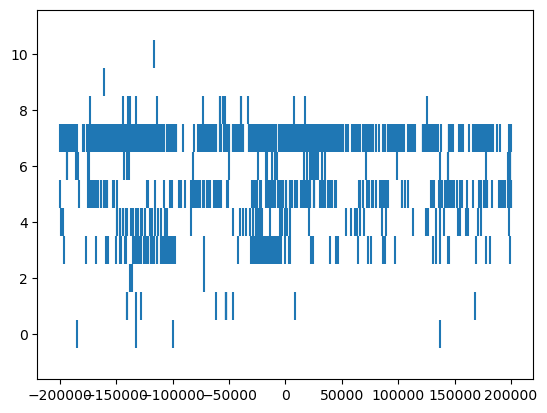

In [66]:
plt.eventplot(example_df["relative_time_to_tone"])

# Calculating average firing rate

In [67]:
merged_spike_trial_df

,spike_clusters,spike_times,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,...,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject,trial_outcome,trial_number,trial_chunked_ephys_timestamp,timestamp_bin,relative_time_to_tone
0,89,8060750,89,11,11,13,17.238409,26,0.0,520.0,...,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[8060195, 8062195, 8064195, 8066195, 8068195, ...",-100,-199445
1,89,8061199,89,11,11,13,17.238409,26,0.0,520.0,...,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[8060195, 8062195, 8064195, 8066195, 8068195, ...",-100,-198996
2,89,8061583,89,11,11,13,17.238409,26,0.0,520.0,...,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[8060195, 8062195, 8064195, 8066195, 8068195, ...",-100,-198612
3,89,8061753,89,11,11,13,17.238409,26,0.0,520.0,...,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[8060195, 8062195, 8064195, 8066195, 8068195, ...",-100,-198442
4,89,8062027,89,11,11,13,17.238409,26,0.0,520.0,...,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[8060195, 8062195, 8064195, 8066195, 8068195, ...",-100,-198168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129045,146,38957244,146,0,0,0,14.943707,6,0.0,120.0,...,NaN,NaN,1858872,"[1.2, 1.4]",1.4,rewarded,22,"[38619710, 38621710, 38623710, 38625710, 38627...",68,137534
129046,146,38957331,146,0,0,0,14.943707,6,0.0,120.0,...,NaN,NaN,1858872,"[1.2, 1.4]",1.4,rewarded,22,"[38619710, 38621710, 38623710, 38625710, 38627...",68,137621
129047,204,38957511,204,1,0,1,11.366614,6,0.0,120.0,...,NaN,NaN,1858872,"[1.2, 1.4]",1.4,rewarded,22,"[38619710, 38621710, 38623710, 38625710, 38627...",68,137801
129048,44,38957537,44,3,1,29,9.739503,17,0.0,340.0,...,NaN,NaN,1858872,"[1.2, 1.4]",1.4,rewarded,22,"[38619710, 38621710, 38623710, 38625710, 38627...",68,137827


In [68]:
grouped_df = merged_spike_trial_df.groupby(["recording_file", "timestamp_bin", "spike_clusters", "trial_outcome", "fr"]).count()[["spike_times"]].reset_index()
# Rename the aggregated column

In [69]:
grouped_df["total_number_of_trials"] = grouped_df.apply(lambda row: total_number_of_trials_dict[(row["recording_file"], row["trial_outcome"])], axis=1)

In [70]:
grouped_df["spike_times"] = grouped_df["spike_times"] / grouped_df["total_number_of_trials"] / grouped_df["fr"]

In [71]:
grouped_df

,recording_file,timestamp_bin,spike_clusters,trial_outcome,fr,spike_times,total_number_of_trials
0,20230619_115321_standard_comp_to_omission_D3_s...,-100,11,lose,2.805744,0.152748,14
1,20230619_115321_standard_comp_to_omission_D3_s...,-100,28,lose,0.860467,0.083011,14
2,20230619_115321_standard_comp_to_omission_D3_s...,-100,44,lose,13.732511,0.062417,14
3,20230619_115321_standard_comp_to_omission_D3_s...,-100,44,rewarded,13.732511,0.084957,6
4,20230619_115321_standard_comp_to_omission_D3_s...,-100,44,win,13.732511,0.058256,5
...,...,...,...,...,...,...,...
27849,20230620_114347_standard_comp_to_omission_D4_s...,99,258,rewarded,2.844826,0.087879,16
27850,20230620_114347_standard_comp_to_omission_D4_s...,99,258,win,2.844826,0.175758,4
27851,20230620_114347_standard_comp_to_omission_D4_s...,99,259,lose,1.757098,0.087557,13
27852,20230620_114347_standard_comp_to_omission_D4_s...,99,259,omission,1.757098,0.284560,4


In [72]:
grouped_df["spike_times"].mean()

0.15091644678675378

In [73]:
pivot_df = grouped_df.pivot_table(index=['recording_file', 'spike_clusters', 'trial_outcome'], columns='timestamp_bin', values='spike_times', fill_value=0).reset_index().set_index("spike_clusters")

In [74]:
pivot_df

timestamp_bin,recording_file,trial_outcome,-100,-99,-98,-97,-96,-95,-94,-93,...,90,91,92,93,94,95,96,97,98,99
spike_clusters,,,,,,,,,,,,,,,,,,,,,
11,20230619_115321_standard_comp_to_omission_D3_s...,lose,0.152748,0.050916,0.050916,0.101832,0.152748,0.152748,0.025458,0.050916,...,0.229122,0.127290,0.050916,0.152748,0.229122,0.254580,0.152748,0.127290,0.280038,0.127290
11,20230619_115321_standard_comp_to_omission_D3_s...,rewarded,0.000000,0.059402,0.059402,0.059402,0.118804,0.178206,0.000000,0.059402,...,0.000000,0.000000,0.059402,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11,20230619_115321_standard_comp_to_omission_D3_s...,win,0.000000,0.071282,0.071282,0.000000,0.071282,0.071282,0.142565,0.071282,...,0.000000,0.142565,0.000000,0.142565,0.000000,0.000000,0.000000,0.000000,0.000000,0.142565
28,20230619_115321_standard_comp_to_omission_D3_s...,lose,0.083011,0.083011,0.249034,0.166023,0.166023,0.581080,0.166023,0.249034,...,0.000000,0.249034,0.000000,0.083011,0.083011,0.166023,0.249034,0.166023,0.249034,0.083011
28,20230619_115321_standard_comp_to_omission_D3_s...,rewarded,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,20230620_114347_standard_comp_to_omission_D4_s...,win,0.087879,0.087879,0.000000,0.175758,0.087879,0.175758,0.087879,0.087879,...,0.087879,0.087879,0.000000,0.000000,0.175758,0.087879,0.175758,0.175758,0.263637,0.175758
259,20230620_114347_standard_comp_to_omission_D4_s...,lose,0.131335,0.087557,0.175114,0.087557,0.043778,0.087557,0.131335,0.131335,...,0.175114,0.087557,0.131335,0.175114,0.175114,0.131335,0.043778,0.131335,0.043778,0.087557
259,20230620_114347_standard_comp_to_omission_D4_s...,omission,0.000000,0.426840,0.000000,0.000000,0.142280,0.000000,0.000000,0.000000,...,0.284560,0.142280,0.000000,0.000000,0.000000,0.284560,0.000000,0.000000,0.142280,0.284560


In [75]:
from matplotlib.colors import LogNorm, Normalize


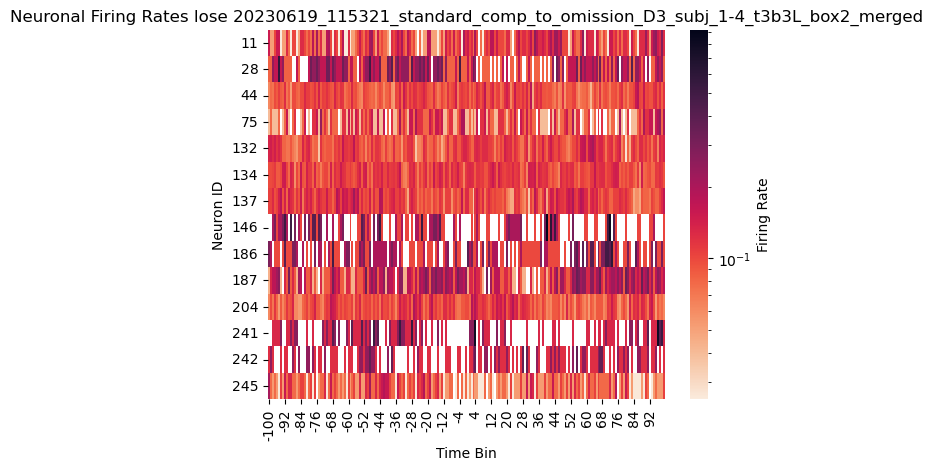

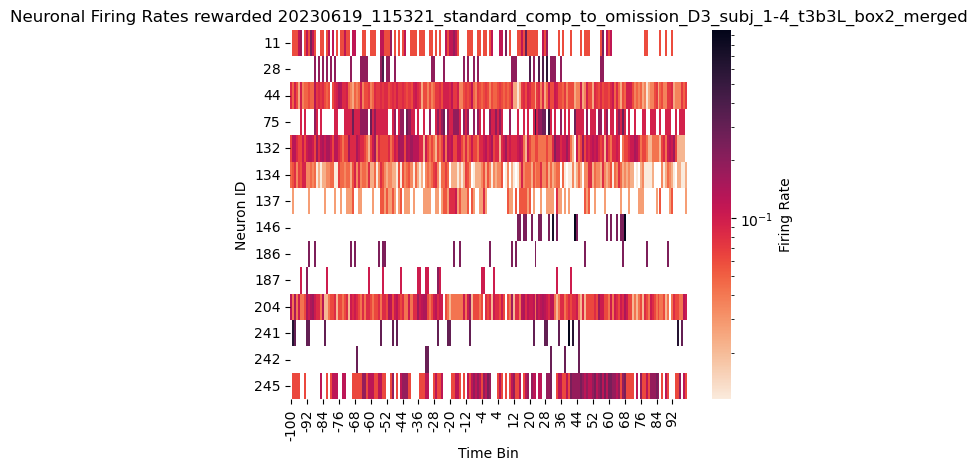

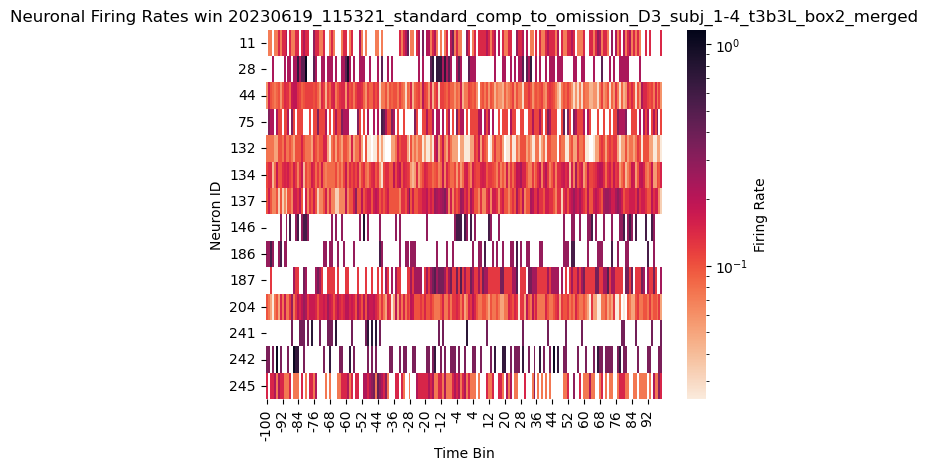

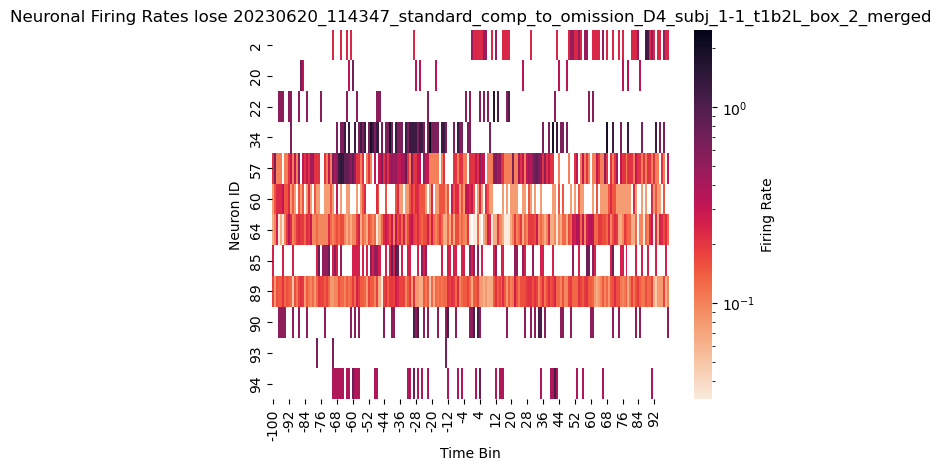

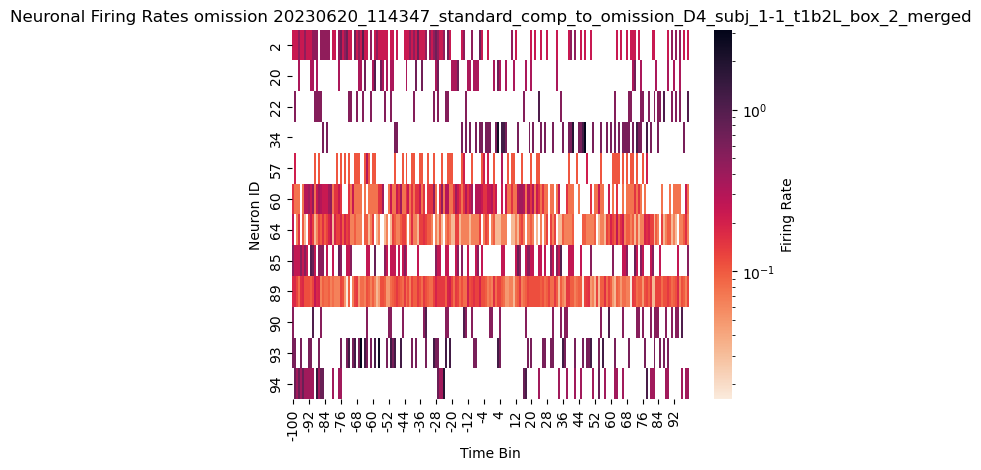

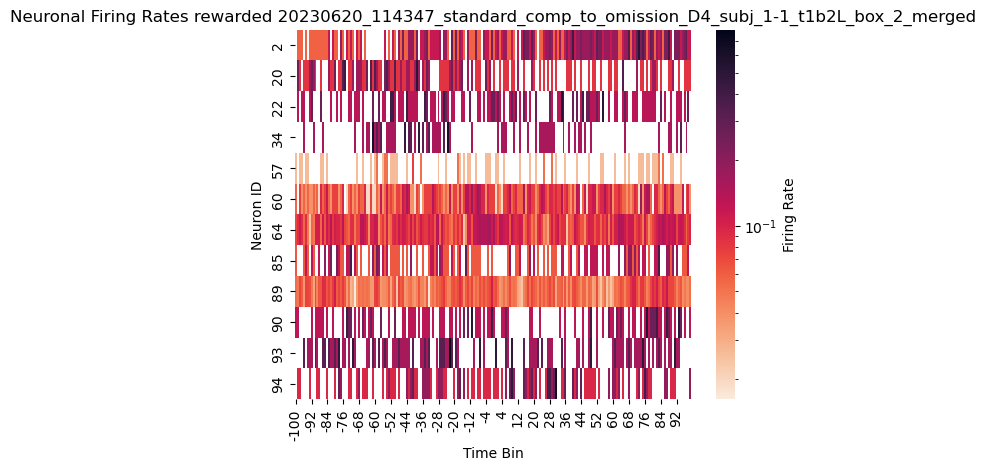

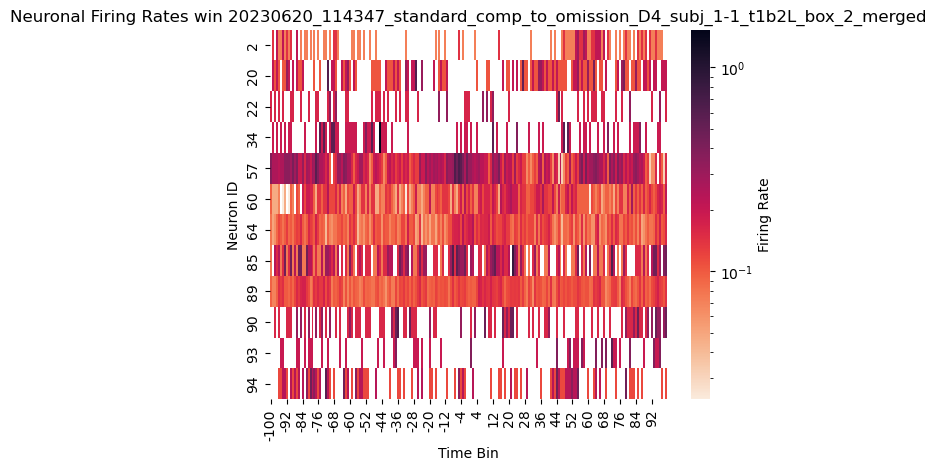

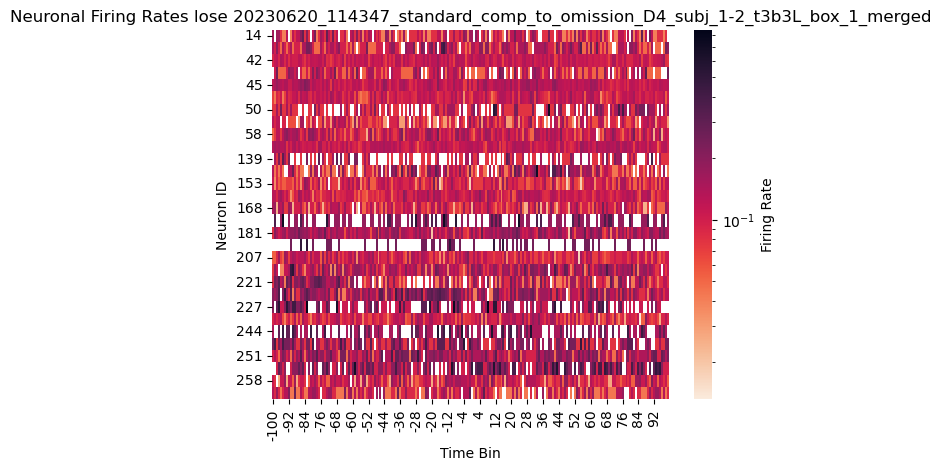

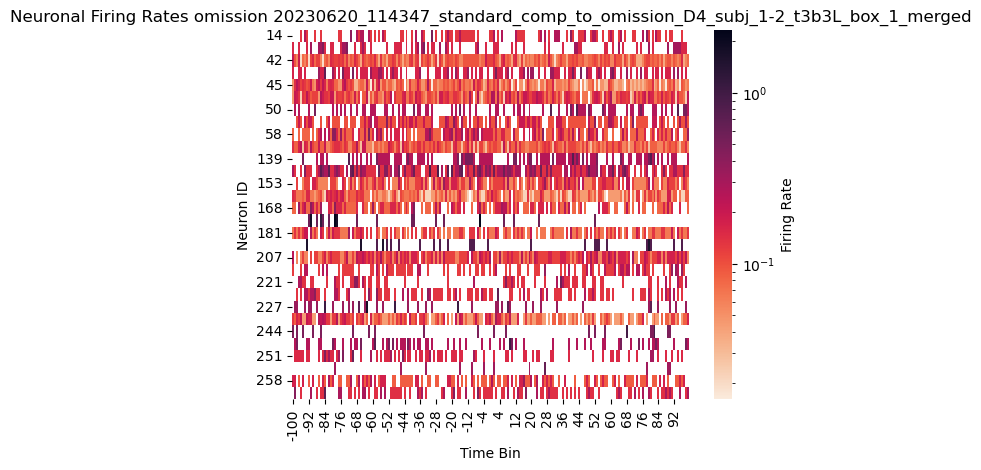

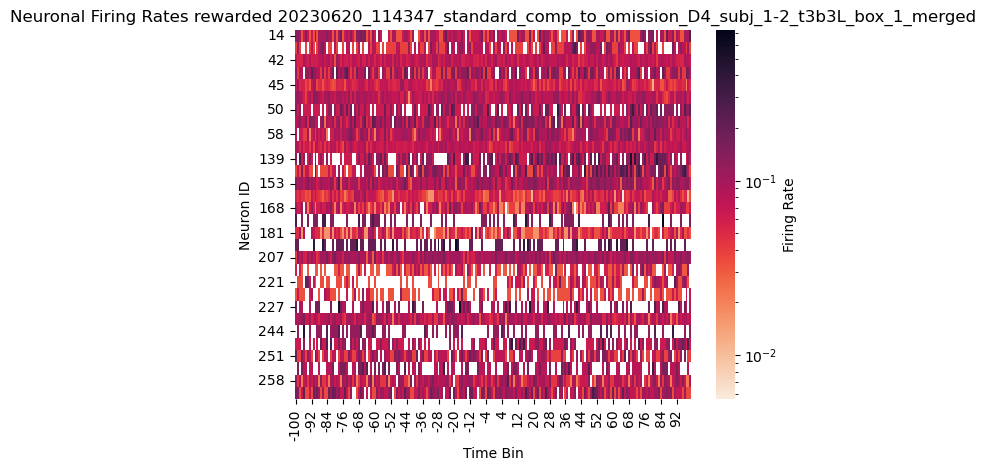

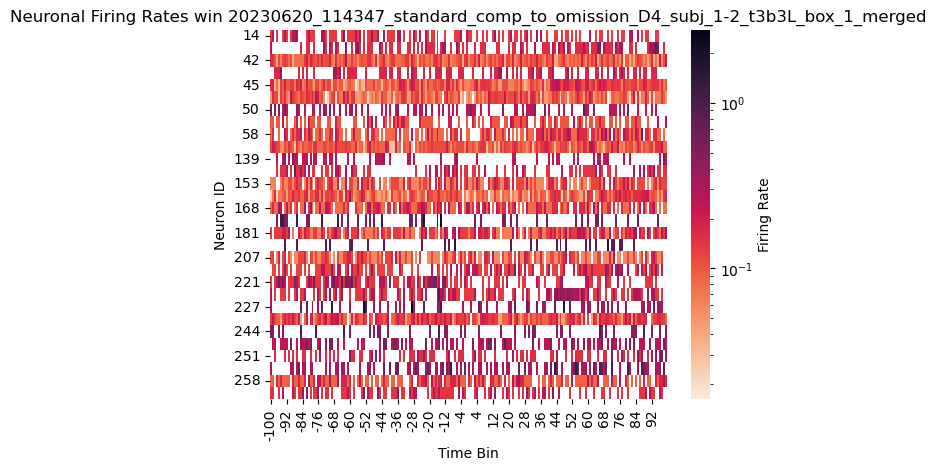

In [76]:
for recording_file in pivot_df["recording_file"].unique():
    recording_df = pivot_df[pivot_df["recording_file"] == recording_file].copy()
    for outcome in recording_df["trial_outcome"].unique():
        outcome_df = recording_df[recording_df["trial_outcome"] == outcome].drop(columns=["recording_file", "trial_outcome"])
        
        sns.heatmap(outcome_df, annot=False, cmap='rocket_r', cbar_kws={'label': 'Firing Rate'}, norm=LogNorm())
        
        # Customizing the plot
        plt.title('Neuronal Firing Rates {} {}'.format(outcome, recording_file))
        plt.xlabel('Time Bin')
        plt.ylabel('Neuron ID')
        
        # Show the plot
        plt.show()


# Plotting PCA

In [77]:
from elephant.gpfa import GPFA
import quantities as pq


In [78]:
grouped_df = merged_spike_trial_df.groupby(["timestamp_bin", "unique_neuron", "trial_outcome", "recording_file"]).count()[["spike_times"]].reset_index()
# Rename the aggregated column

KeyError: 'unique_neuron'

In [ ]:
grouped_df

In [ ]:
grouped_df["spike_times"].mean()

In [ ]:
pivot_df = grouped_df.pivot_table(index=['unique_neuron'], columns='time_bin_and_outcome', values='spike_times', fill_value=0).reset_index().set_index("unique_neuron")

In [ ]:
pivot_df.head()

In [ ]:
# performing preprocessing part
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [ ]:
pivot_df.to_numpy()

In [ ]:
scaled_firing_rates = sc.fit_transform(pivot_df.to_numpy())


In [ ]:
# Applying PCA function on training
# and testing set of X component
from sklearn.decomposition import PCA
 


In [ ]:
pca = PCA(n_components = 2)



In [ ]:
pca_firing_rates = pca.fit_transform(scaled_firing_rates)


In [ ]:
principal_df = pd.DataFrame(data = pca_firing_rates
             , columns = ['principal component 1', 'principal component 2'])

In [ ]:
principal_df.head()

In [ ]:
pc1_product = pivot_df.reset_index(drop=True).multiply(principal_df["principal component 1"], axis="index")

In [ ]:
pc2_product = pivot_df.reset_index(drop=True).multiply(principal_df["principal component 2"], axis="index")

In [ ]:
pc_product = pd.concat([pc1_product.mean(), pc2_product.mean()], axis=1).reset_index()

In [ ]:
pc_product

In [ ]:
import string

In [ ]:
pc_product["bin_time"] = pc_product["time_bin_and_outcome"].apply(lambda x: int(x.split("_")[0]))
pc_product["trial_type"] = pc_product["time_bin_and_outcome"].apply(lambda x: (x.split("_")[1]))

In [ ]:
outcome_to_color = {"lose": "orange", "rewarded": "green", "win": "blue", "omission": "red"}

In [ ]:
pc_product["color"] = pc_product["trial_type"].map(outcome_to_color)

In [362]:
pc_product

,time_bin_and_outcome,0,1,bin_time,trial_type,color
0,-100_lose,10.980402,0.385250,-100,lose,orange
1,-100_omission,10.575198,-1.913491,-100,omission,red
2,-100_rewarded,6.875799,0.233564,-100,rewarded,green
3,-100_win,9.883856,0.776286,-100,win,blue
4,-10_lose,13.648423,0.296845,-10,lose,orange
...,...,...,...,...,...,...
795,99_win,11.473663,0.448708,99,win,blue
796,9_lose,11.225504,1.193776,9,lose,orange
797,9_omission,8.948628,-1.840060,9,omission,red
798,9_rewarded,6.316874,-0.093901,9,rewarded,green


In [363]:
def smoothdata(arr, method='moving_average', window_length=5):
    """
    A simplified version of MATLAB's smoothdata function.
    
    Parameters:
        arr (array-like): The data to be smoothed.
        method (str): The smoothing method - 'moving_average', 'gaussian', or 'savgol'.
        window_length (int): The length of the window used for smoothing.
        
    Returns:
        np.ndarray: The smoothed data.
    """
    arr = np.asarray(arr)
    
    if method == 'moving_average':
        kernel = np.ones(window_length) / window_length
        smoothed = np.convolve(arr, kernel, 'same')
        
    elif method == 'gaussian':
        kernel = gaussian(window_length, std=window_length/3)
        kernel /= np.sum(kernel)
        smoothed = np.convolve(arr, kernel, 'same')
        
    elif method == 'savgol':
        if window_length % 2 == 0:
            window_length += 1
        smoothed = savgol_filter(arr, window_length, polyorder=2)
        
    else:
        raise ValueError(f"Unknown method: {method}")
        
    return smoothed

In [367]:
from scipy.ndimage import gaussian_filter

In [369]:
for outcome in pc_product["trial_type"].unique():
    outcome_df = pc_product[pc_product["trial_type"] == outcome].sort_values("bin_time")
    smoothed_line = gaussian_filter(pc_product[[0,1]].to_numpy(), sigma=1)

In [384]:
from scipy.ndimage import uniform_filter



In [ ]:
def smooth_averaging(array, size):
    return uniform_filter(array, size=size)

In [388]:
outcome_df[[0,1]].to_numpy().shape

(200, 2)

In [397]:
smoothed_line[1]

array([5.33007088, 6.16783743, 5.91107235, 4.15895315, 3.86111183,
       5.00995584, 5.4329506 , 5.5256362 , 5.62653826, 5.7035733 ,
       6.31377778, 6.32493432, 5.53895263, 5.86566757, 6.81922116,
       7.08244015, 6.36490219, 5.89728347, 7.1792207 , 6.337767  ,
       5.35545736, 5.70416462, 5.43181271, 6.41781722, 7.35849725,
       6.16703321, 5.51571659, 5.86654058, 5.71859849, 5.9202692 ,
       5.67585448, 4.84241247, 4.63284732, 5.17798689, 5.24314552,
       5.12054973, 5.22867366, 4.94166982, 5.29888428, 5.53484296,
       5.69746593, 5.81718139, 5.25654738, 4.90421313, 4.40649459,
       4.44565241, 5.31121889, 5.25744685, 5.00786155, 5.08659114,
       4.72955281, 4.56384246, 4.88234864, 5.30421581, 5.51029401,
       4.99695117, 4.64390114, 4.25190316, 3.80006753, 4.23802115,
       4.23321666, 4.68278115, 4.9775117 , 4.52998305, 4.84205683,
       5.82664106, 6.30215264, 6.87574964, 6.52523881, 5.36126392,
       5.04665917, 5.99761519, 6.48116919, 5.58481761, 4.83810

In [401]:
from scipy.ndimage.filters import gaussian_filter1d


/tmp/ipykernel_2819635/1543485559.py:1: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [482]:
sigma = 3
divider = 5

In [483]:
smoothed_x

array([10.70044396, 11.183164  , 11.04883067, 10.58141443,  9.98307944,
        8.90523934,  8.18216338,  8.63449737,  9.47417736,  9.76623336,
        9.82806529, 10.12843699,  9.66603479,  9.05011819,  9.25339277,
        9.97388854, 10.13435542,  9.4793039 ,  9.34964827,  9.93943003])

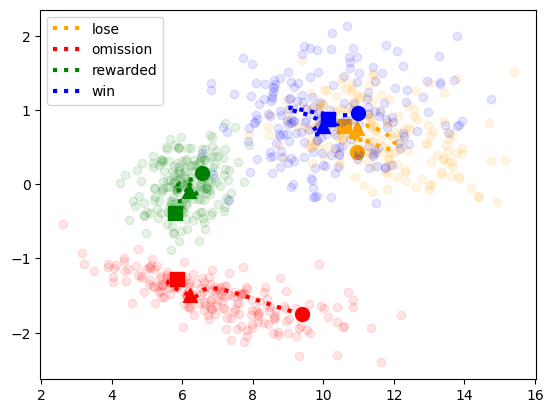

In [484]:
# Create scatter plot
# plt.plot(pc_product[0], pc_product[1], color=pc_product["color"])

for outcome in pc_product["trial_type"].unique():
    
    outcome_df = pc_product[pc_product["trial_type"] == outcome].sort_values("bin_time")
    plt.scatter(outcome_df[0], outcome_df[1], color=outcome_to_color[outcome], alpha=0.1)
    
    smoothed_x = gaussian_filter1d(outcome_df[0][::divider], sigma=sigma)
    
    # smoothed_x = outcome_df[0].rolling(window=10).mean()[::10]
    smoothed_y = gaussian_filter1d(outcome_df[1][::divider], sigma=sigma)
    # smoothed_y = outcome_df[1].rolling(window=10).mean()[::10]

    plt.scatter(smoothed_x[0], smoothed_y[0], color=outcome_to_color[outcome], marker = 'o', s=100)
    plt.scatter(smoothed_x[len(smoothed_x)//2], smoothed_y[len(smoothed_y)//2], color=outcome_to_color[outcome], marker = '^', s=100)
    plt.scatter(smoothed_x[len(smoothed_x)-1], smoothed_y[len(smoothed_y)-1], color=outcome_to_color[outcome], marker = 's', s=100)

    
    # Create smoothed line plot
    plt.plot(smoothed_x, smoothed_y, color=outcome_to_color[outcome], ls=':', label=outcome, linewidth=3)

plt.legend()

# Show plot
plt.show()

In [442]:
pc_product["color"]

0      orange
1         red
2       green
3        blue
4      orange
        ...  
795      blue
796    orange
797       red
798     green
799      blue
Name: color, Length: 800, dtype: object

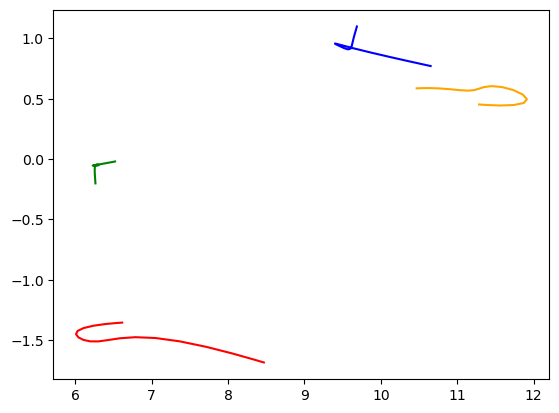

In [430]:
# Create scatter plot
# sns.scatterplot(data=pc_product, x=0, y=1, hue='trial_type',  palette=outcome_to_color)

for outcome in pc_product["trial_type"].unique():
    outcome_df = pc_product[pc_product["trial_type"] == outcome].sort_values("bin_time")
    smoothed_x = gaussian_filter1d(outcome_df[0][::10], sigma=sigma)
    # smoothed_x = outcome_df[0].rolling(window=10).mean()[::10]
    smoothed_y = gaussian_filter1d(outcome_df[1][::10], sigma=sigma)
    # smoothed_y = outcome_df[1].rolling(window=10).mean()[::10]

    # Create smoothed line plot
    plt.plot(smoothed_x, smoothed_y, color=outcome_to_color[outcome])


# Show plot
plt.show()

In [409]:
smoothed_y

3           NaN
395         NaN
391         NaN
387         NaN
383         NaN
         ...   
779    0.983286
783    1.011719
787    0.932929
791    0.893994
795    0.738535
Name: 1, Length: 200, dtype: float64

In [381]:
outcome_df[[0,1]].to_numpy().shape

(200, 2)

In [383]:
smoothed_line.shape

(200, 2)

In [378]:
smoothed_line

array([[6.74677013, 3.56707399],
       [6.11319446, 3.10376556],
       [5.82400448, 3.12852187],
       ...,
       [5.75242152, 2.99672082],
       [5.58397053, 3.07755214],
       [6.4338704 , 3.90731126]])

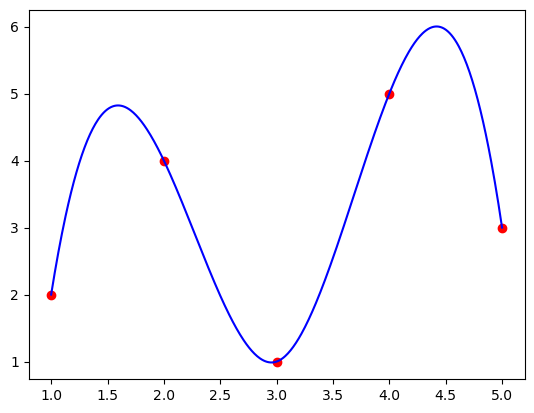

In [361]:
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import numpy as np

# Sample PCA data
x = np.array([1, 2, 3, 4, 5])
y = np.array([2, 4, 1, 5, 3])

# Sort data by x
sort_idx = np.argsort(x)
x = x[sort_idx]
y = y[sort_idx]

# Create a cubic spline interpolation
cs = CubicSpline(x, y)

# Create new x and y values
x_new = np.linspace(x.min(), x.max(), 500)
y_new = cs(x_new)

# Plot the original points and the smoothed curve
plt.scatter(x, y, color='red')
plt.plot(x_new, y_new, color='blue')
plt.show()

In [353]:
pc_product

,time_bin_and_outcome,0,1,bin_time,trial_type
0,-100_lose,10.980402,0.385250,-100,lose
1,-100_omission,10.575198,-1.913491,-100,omission
2,-100_rewarded,6.875799,0.233564,-100,rewarded
3,-100_win,9.883856,0.776286,-100,win
4,-10_lose,13.648423,0.296845,-10,lose
...,...,...,...,...,...
795,99_win,11.473663,0.448708,99,win
796,9_lose,11.225504,1.193776,9,lose
797,9_omission,8.948628,-1.840060,9,omission
798,9_rewarded,6.316874,-0.093901,9,rewarded


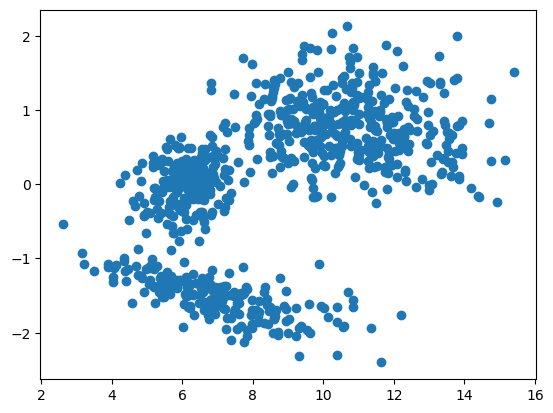

In [351]:
plt.scatter(pc_product[0], pc_product[1])

In [ ]:

 
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [235]:
len(pivot_df.groupby(["recording_file", "trial_number"]).count())

93

In [237]:
import numpy as np
from scipy.integrate import odeint
import quantities as pq
import neo
from elephant.spike_train_generation import inhomogeneous_poisson_process


def integrated_oscillator(dt, num_steps, x0=0, y0=1, angular_frequency=2*np.pi*1e-3):
    """
    Parameters
    ----------
    dt : float
        Integration time step in ms.
    num_steps : int
        Number of integration steps -> max_time = dt*(num_steps-1).
    x0, y0 : float
        Initial values in three dimensional space.
    angular_frequency : float
        Angular frequency in 1/ms.

    Returns
    -------
    t : (num_steps) np.ndarray
        Array of timepoints
    (2, num_steps) np.ndarray
        Integrated two-dimensional trajectory (x, y, z) of the harmonic oscillator
    """

    assert isinstance(num_steps, int), "num_steps has to be integer"
    t = dt*np.arange(num_steps)
    x = x0*np.cos(angular_frequency*t) + y0*np.sin(angular_frequency*t)
    y = -x0*np.sin(angular_frequency*t) + y0*np.cos(angular_frequency*t)
    return t, np.array((x, y))


def integrated_lorenz(dt, num_steps, x0=0, y0=1, z0=1.05,
                      sigma=10, rho=28, beta=2.667, tau=1e3):
    """

    Parameters
    ----------
    dt :
        Integration time step in ms.
    num_steps : int
        Number of integration steps -> max_time = dt*(num_steps-1).
    x0, y0, z0 : float
        Initial values in three dimensional space
    sigma, rho, beta : float
        Parameters defining the lorenz attractor
    tau : characteristic timescale in ms

    Returns
    -------
    t : (num_steps) np.ndarray
        Array of timepoints
    (3, num_steps) np.ndarray
        Integrated three-dimensional trajectory (x, y, z) of the Lorenz attractor
    """
    def _lorenz_ode(point_of_interest, timepoint, sigma, rho, beta, tau):
        """
        Fit the model with `spiketrains` data and apply the dimensionality
        reduction on `spiketrains`.

        Parameters
        ----------
        point_of_interest : tuple
            Tupel containing coordinates (x,y,z) in three dimensional space.
        timepoint : a point of interest in time
        dt :
            Integration time step in ms.
        num_steps : int
            Number of integration steps -> max_time = dt*(num_steps-1).
        sigma, rho, beta : float
            Parameters defining the lorenz attractor
        tau : characteristic timescale in ms

        Returns
        -------
        x_dot, y_dot, z_dot : float
            Values of the lorenz attractor's partial derivatives
            at the point x, y, z.
        """

        x, y, z = point_of_interest

        x_dot = (sigma*(y - x)) / tau
        y_dot = (rho*x - y - x*z) / tau
        z_dot = (x*y - beta*z) / tau
        return x_dot, y_dot, z_dot

    assert isinstance(num_steps, int), "num_steps has to be integer"

    t = dt*np.arange(num_steps)
    poi = (x0, y0, z0)
    return t, odeint(_lorenz_ode, poi, t, args=(sigma, rho, beta, tau)).T


def random_projection(data, embedding_dimension, loc=0, scale=None):
    """
    Parameters
    ----------
    data : np.ndarray
        Data to embed, shape=(M, N)
    embedding_dimension : int
        Embedding dimension, dimensionality of the space to project to.
    loc : float or array_like of floats
        Mean (“centre”) of the distribution.
    scale : float or array_like of floats
        Standard deviation (spread or “width”) of the distribution.

    Returns
    -------
    np.ndarray
       Random (normal) projection of input data, shape=(dim, N)

    See Also
    --------
    np.random.normal()

    """
    if scale is None:
        scale = 1 / np.sqrt(data.shape[0])
    projection_matrix = np.random.normal(loc, scale, (embedding_dimension, data.shape[0]))
    return np.dot(projection_matrix, data)


def generate_spiketrains(instantaneous_rates, num_trials, timestep):
    """
    Parameters
    ----------
    instantaneous_rates : np.ndarray
        Array containing time series.
    timestep :
        Sample period.
    num_steps : int
        Number of timesteps -> max_time = timestep*(num_steps-1).

    Returns
    -------
    spiketrains : list of neo.SpikeTrains
        List containing spiketrains of inhomogeneous Poisson
        processes based on given instantaneous rates.

    """

    spiketrains = []
    for _ in range(num_trials):
        spiketrains_per_trial = []
        for inst_rate in instantaneous_rates:
            anasig_inst_rate = neo.AnalogSignal(inst_rate, sampling_rate=1/timestep, units=pq.Hz)
            spiketrains_per_trial.append(inhomogeneous_poisson_process(anasig_inst_rate))
        spiketrains.append(spiketrains_per_trial)

    return spiketrains

In [238]:
# set parameters for the integration of the harmonic oscillator
timestep = 1 * pq.ms
trial_duration = 2 * pq.s
num_steps = int((trial_duration.rescale('ms')/timestep).magnitude)

# set parameters for spike train generation
max_rate = 70 * pq.Hz
np.random.seed(42)  # for visualization purposes, we want to get identical spike trains at any run

# specify data size
num_trials = 20
num_spiketrains = 50

# generate a low-dimensional trajectory
times_oscillator, oscillator_trajectory_2dim = integrated_oscillator(
    timestep.magnitude, num_steps=num_steps, x0=0, y0=1)
times_oscillator = (times_oscillator*timestep.units).rescale('s')

# random projection to high-dimensional space
oscillator_trajectory_Ndim = random_projection(
    oscillator_trajectory_2dim, embedding_dimension=num_spiketrains)

# convert to instantaneous rate for Poisson process
normed_traj = oscillator_trajectory_Ndim / oscillator_trajectory_Ndim.max()
instantaneous_rates_oscillator = np.power(max_rate.magnitude, normed_traj)

# generate spike trains
spiketrains_oscillator = generate_spiketrains(
    instantaneous_rates_oscillator, num_trials, timestep)

In [247]:
type(spiketrains_oscillator[0][0])

neo.core.spiketrain.SpikeTrain

In [225]:


# specify fitting parameters
bin_size = 10 * pq.ms
latent_dimensionality = 2

gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

In [249]:
pivot_df

timestamp_bin,recording_file,trial_outcome,trial_number,-100,-99,-98,-97,-96,-95,-94,...,90,91,92,93,94,95,96,97,98,99
spike_clusters,,,,,,,,,,,,,,,,,,,,,
11,20230619_115321_standard_comp_to_omission_D3_s...,lose,3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0
11,20230619_115321_standard_comp_to_omission_D3_s...,lose,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,0.0
11,20230619_115321_standard_comp_to_omission_D3_s...,lose,7,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
11,20230619_115321_standard_comp_to_omission_D3_s...,lose,8,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0
11,20230619_115321_standard_comp_to_omission_D3_s...,lose,9,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,20230620_114347_standard_comp_to_omission_D4_s...,rewarded,34,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
259,20230620_114347_standard_comp_to_omission_D4_s...,win,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
259,20230620_114347_standard_comp_to_omission_D4_s...,win,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [248]:
gpfa_2dim.fit(oscillator_trajectory_2dim)
print(gpfa_2dim.params_estimated.keys())

ValueError: structure of the spiketrains is not correct: 0-axis should be trials, 1-axis neo.SpikeTrainand 2-axis spike times

In [226]:
trajectories = gpfa_2dim.transform(pivot_df)


AttributeError: 'GPFA' object has no attribute 'has_spikes_bool'

In [150]:
outcome_df

timestamp_bin,-100,-99,-98,-97,-96,-95,-94,-93,-92,-91,...,90,91,92,93,94,95,96,97,98,99
spike_clusters,,,,,,,,,,,,,,,,,,,,,
14,4.0,0.0,4.0,4.0,2.0,1.0,1.0,3.0,0.0,1.0,...,6.0,3.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,0.0
41,3.0,2.0,4.0,2.0,1.0,3.0,2.0,1.0,2.0,3.0,...,1.0,3.0,0.0,1.0,1.0,1.0,0.0,1.0,5.0,4.0
42,15.0,19.0,21.0,15.0,24.0,22.0,15.0,21.0,14.0,19.0,...,12.0,15.0,18.0,18.0,19.0,19.0,22.0,29.0,14.0,13.0
43,0.0,2.0,5.0,1.0,1.0,1.0,1.0,2.0,4.0,3.0,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,5.0
45,24.0,29.0,35.0,30.0,27.0,24.0,29.0,29.0,21.0,21.0,...,19.0,22.0,24.0,24.0,22.0,28.0,26.0,24.0,24.0,27.0
48,10.0,6.0,13.0,11.0,15.0,6.0,10.0,18.0,12.0,13.0,...,15.0,14.0,18.0,12.0,14.0,15.0,15.0,19.0,8.0,15.0
50,1.0,1.0,2.0,1.0,3.0,1.0,1.0,2.0,1.0,2.0,...,2.0,2.0,2.0,1.0,0.0,2.0,0.0,2.0,1.0,2.0
53,4.0,3.0,4.0,4.0,0.0,3.0,3.0,0.0,2.0,2.0,...,3.0,4.0,5.0,1.0,3.0,4.0,3.0,3.0,3.0,1.0
58,2.0,3.0,5.0,5.0,3.0,5.0,7.0,8.0,6.0,5.0,...,4.0,6.0,1.0,5.0,4.0,8.0,1.0,4.0,5.0,4.0


In [133]:
df_pivot

time_bin,1,2,3
neuron_id,,,
N1,12,18,20
N2,10,11,14
N3,9,12,13


In [ ]:
# Loop through each group to fill missing timestamps
for group, group_df in pivot_df.groupby(["recording_file", "spike_clusters", "trial_outcome"]):
    # Reindex to include all timestamps
    new_group_df = group_df.set_index('timestamp_bin').reindex(all_timestamps)
    
    # Fill missing group and value columns
    new_group_df['Group'].fillna(group, inplace=True)
    new_group_df['Value'].fillna(0, inplace=True)  # Fill with a default value (0 here)
    
    # Append the result to the result DataFrame
    result_df = pd.concat([result_df, new_group_df.reset_index()])

# Reset the DataFrame index
result_df.reset_index(drop=True, inplace=True)

In [ ]:
raise ValueError()

In [115]:
# Get unique combinations of Group1 and Group2, and unique categories
unique_groups = grouped_df[['recording_file' , 'spike_clusters', 'trial_outcome']].drop_duplicates()
unique_categories = grouped_df["timestamp_bin"].unique()

In [116]:
# Initialize an empty list to store new rows
new_rows = []

In [117]:
# Iterate through the unique group combinations and categories to find missing rows
for _, row in unique_groups.iterrows():
    recording_file, trial_outcome, spike_clusters = row['recording_file'], row['trial_outcome'], row["spike_clusters"]
    for timestamp_bin in unique_categories:
        if grouped_df[(grouped_df['recording_file'] == recording_file) & (grouped_df['trial_outcome'] == trial_outcome) & (grouped_df['spike_clusters'] == spike_clusters) & (grouped_df['timestamp_bin'] == timestamp_bin)].empty:
            new_row = {'recording_file': recording_file, 'trial_outcome': trial_outcome, 'spike_clusters': spike_clusters, 'timestamp_bin': timestamp_bin, 'spike_times': 0}
            new_rows.append(new_row)

KeyboardInterrupt: 

In [ ]:
# Create a DataFrame from the list of new rows
new_rows_df = pd.DataFrame(new_rows)

# Append the new rows to the original DataFrame and pivot again
grouped_df = pd.concat([grouped_df, new_rows_df], ignore_index=True)
pivot_df = pd.pivot_table(grouped_df, values='Value', index=['recording_file', 'trial_outcome', 'spike_clusters'], columns='timestamp_bin')

print(pivot_df)

In [109]:
# Initialize an empty list to store new rows
new_rows = []

# Iterate through the unique group combinations and categories to find missing rows
for _, row in unique_groups.iterrows():
    recording_file, trial_outcome, spike_clusters = row['recording_file'], row['trial_outcome'], row["spike_clusters"]
    for timestamp_bin in unique_categories:
        if grouped_df[(grouped_df['recording_file'] == recording_file) & (grouped_df['trial_outcome'] == trial_outcome) & (grouped_df['spike_clusters'] == spike_clusters) & (grouped_df['timestamp_bin'] == timestamp_bin)].empty:
            new_row = {'recording_file': recording_file, 'trial_outcome': trial_outcome, 'spike_clusters': spike_clusters, 'timestamp_bin': timestamp_bin, 'spike_times': 0}
            new_rows.append(new_row)

# Create a DataFrame from the list of new rows
new_rows_df = pd.DataFrame(new_rows)

# Append the new rows to the original DataFrame and pivot again
grouped_df = pd.concat([grouped_df, new_rows_df], ignore_index=True)
pivot_df = pd.pivot_table(grouped_df, values='Value', index=['recording_file', 'trial_outcome', 'spike_clusters'], columns='timestamp_bin')

print(pivot_df)

KeyboardInterrupt: 

In [ ]:
# Get unique combinations of Group1 and Group2, and unique categories
unique_groups = grouped_df[['recording_file' , 'spike_clusters', 'trial_outcome']].drop_duplicates()
unique_categories = grouped_df["timestamp_bin"].unique()

# Initialize an empty list to store new rows
new_rows = []

# Iterate through the unique group combinations and categories to find missing rows
for _, row in unique_groups.iterrows():
    group1, group2 = row['Group1'], row['Group2']
    for category in unique_categories:
        if df[(df['Group1'] == group1) & (df['Group2'] == group2) & (df['Category'] == category)].empty:
            new_row = {'Group1': group1, 'Group2': group2, 'Category': category, 'Value': None}
            new_rows.append(new_row)

# Create a DataFrame from the list of new rows
new_rows_df = pd.DataFrame(new_rows)

# Append the new rows to the original DataFrame and pivot again
df = pd.concat([df, new_rows_df], ignore_index=True)
pivot_df = pd.pivot_table(df, values='Value', index=['Group1', 'Group2'], columns='Category')

print(pivot_df)

In [ ]:
# Get unique groups and categories
unique_groups = df['Group'].unique()
unique_categories = [1, 2, 3]

# Initialize an empty list to store new rows
new_rows = []

# Iterate through the unique groups and categories to find missing rows
for group in unique_groups:
    for category in unique_categories:
        if df[(df['Group'] == group) & (df['Category'] == category)].empty:
            new_row = {'Group': group, 'Category': category, 'Value': None}
            new_rows.append(new_row)

# Create a DataFrame from the list of new rows
new_rows_df = pd.DataFrame(new_rows)

# Append the new rows to the original DataFrame and pivot again
df = pd.concat([df, new_rows_df], ignore_index=True)
pivot_df = df.pivot(index='Group', columns='Category', values='Value')

In [99]:
for recording_file in pivot_df["recording_file"].unique():
    recording_df = pivot_df[pivot_df["recording_file"] == recording_file].copy()
    for outcome in recording_df["trial_outcome"].unique():
        outcome_df = recording_df[recording_df["trial_outcome"] == outcome]
        break

In [102]:
len(outcome_df["spike_clusters"].unique())

30

In [106]:
outcome_df.groupby(["spike_clusters"]).count()

timestamp_bin,recording_file,timestamp_bin,trial_outcome,-100,-99,-98,-97,-96,-95,-94,...,90,91,92,93,94,95,96,97,98,99
spike_clusters,,,,,,,,,,,,,,,,,,,,,
14,178,178,178,178,178,178,178,178,178,178,...,178,178,178,178,178,178,178,178,178,178
41,186,186,186,186,186,186,186,186,186,186,...,186,186,186,186,186,186,186,186,186,186
42,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200
43,172,172,172,172,172,172,172,172,172,172,...,172,172,172,172,172,172,172,172,172,172
45,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200
48,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200
50,148,148,148,148,148,148,148,148,148,148,...,148,148,148,148,148,148,148,148,148,148
53,180,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180,180,180,180
58,199,199,199,199,199,199,199,199,199,199,...,199,199,199,199,199,199,199,199,199,199


In [103]:
outcome_df

timestamp_bin,recording_file,timestamp_bin,spike_clusters,trial_outcome,-100,-99,-98,-97,-96,-95,...,90,91,92,93,94,95,96,97,98,99
10692,20230620_114347_standard_comp_to_omission_D4_s...,-100,14,lose,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10695,20230620_114347_standard_comp_to_omission_D4_s...,-100,41,lose,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10699,20230620_114347_standard_comp_to_omission_D4_s...,-100,42,lose,15.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10705,20230620_114347_standard_comp_to_omission_D4_s...,-100,45,lose,24.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10709,20230620_114347_standard_comp_to_omission_D4_s...,-100,48,lose,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27840,20230620_114347_standard_comp_to_omission_D4_s...,99,245,lose,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
27844,20230620_114347_standard_comp_to_omission_D4_s...,99,251,lose,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
27847,20230620_114347_standard_comp_to_omission_D4_s...,99,254,lose,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
27848,20230620_114347_standard_comp_to_omission_D4_s...,99,258,lose,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [96]:
pivot_df.reset_index()

timestamp_bin,recording_file,timestamp_bin,spike_clusters,trial_outcome,-100,-99,-98,-97,-96,-95,...,90,91,92,93,94,95,96,97,98,99
0,20230619_115321_standard_comp_to_omission_D3_s...,-100,11,lose,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20230619_115321_standard_comp_to_omission_D3_s...,-100,28,lose,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20230619_115321_standard_comp_to_omission_D3_s...,-100,44,lose,12.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20230619_115321_standard_comp_to_omission_D3_s...,-100,44,rewarded,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20230619_115321_standard_comp_to_omission_D3_s...,-100,44,win,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27849,20230620_114347_standard_comp_to_omission_D4_s...,99,258,rewarded,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
27850,20230620_114347_standard_comp_to_omission_D4_s...,99,258,win,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
27851,20230620_114347_standard_comp_to_omission_D4_s...,99,259,lose,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
27852,20230620_114347_standard_comp_to_omission_D4_s...,99,259,omission,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [ ]:
# Getting a list of all the trials for each recording
recording_to_neuron_to_trial_timestamp = defaultdict(dict)
# Loop through each unique key
for key in merged_spike_trial_df['recording_file'].unique():
    # Filter the DataFrame based on the key and get the 'Value' column as a list
    recording_to_trials[key] = all_trials_df[all_trials_df['recording_file'] == key]['time'].tolist()


In [ ]:
merged_spike_trial_df

In [57]:
raise ValueError()

ValueError: 

In [ ]:
merged_spike_trial_df.head()

In [ ]:
plt.eventplot()

In [ ]:
merged_spike_trial_df["recording_file"]
merged_spike_trial_df[""]

In [ ]:
raise ValueError()

In [ ]:
merged_spike_trial_df = pd.merge(left=all_spike_time_df, right=all_trials_df, left_on="recording_name", right_on="recording_file", how="left")

In [ ]:
all_trials_df

In [ ]:
spike_times

In [ ]:
spike_clusters

In [ ]:
spike_df

In [ ]:
spike_clusters

In [ ]:
recording_to_spike_df[list(recording_to_spike_df.keys())[0]].head()

In [ ]:
list(recording_to_spike_df.keys())[0]

In [ ]:
current_df = recording_to_spike_df[list(recording_to_spike_df.keys())[0]]

In [ ]:
current_df = current_df[current_df["spike_clusters"]==9]

In [ ]:
epsilon = 1e-10


In [ ]:
current_df["current_isi"] = current_df["current_isi"] + epsilon

In [ ]:
bins = np.linspace(0, 0.01, num=11)

In [ ]:
bins

In [ ]:
sns.histplot(current_df["current_isi"], bins=bins)


In [ ]:
recording_to_spike_df[list(recording_to_spike_df.keys())[0]].tail()

In [ ]:
current_df["cluster_id"].unique()

In [ ]:
bins = np.linspace(0, 0.05, num=51)

In [ ]:
current_df = recording_to_spike_df[list(recording_to_spike_df.keys())[0]]
for id in sorted(current_df["cluster_id"].unique()):
    try:
        unit_df = current_df[current_df["spike_clusters"]==id]
        n_spikes = unit_df["n_spikes"].iloc[0]
        counts, bin_edges = np.histogram(unit_df["current_isi"], bins=bins)
        # print(counts)
        # if counts[0] + counts[1] <= n_spikes / 1000:
        fig, ax = plt.subplots()
        sns.histplot(unit_df["current_isi"], bins=bin_edges, kde=False)        
        plt.title("Unit {} with {} spikes and {} + {} in ISI bars at {} {} ISI Ratio".format(id, n_spikes, counts[0], counts[1], round(counts[0]/ n_spikes * 1000, 4), round(counts[1] / n_spikes * 1000, 4)))
        plt.show()
        plt.close()
    except Exception as e: 
        print(e)        
        continue
    

In [ ]:
raise ValueError()

# Labeling before or after

In [ ]:
recording_to_spike_df.keys()

In [ ]:
all_trials_df = all_trials_df[all_trials_df["recording_file"].isin(recording_to_spike_df.keys())].reset_index(drop=True)

In [ ]:
all_trials_df.head()

# Calculating the firing rate

In [ ]:
all_trials_df.columns

In [ ]:
all_trials_df.head()

In [ ]:
grouped_trials_df = all_trials_df.groupby(["recording_file", "current_subject", "video_number"]).agg({
    'time_stamp_index': list,
    'trial_outcome': list,
    'competition_closeness': list}).reset_index()

In [ ]:
grouped_trials_df.head()

In [ ]:
grouped_trials_df = grouped_trials_df.drop_duplicates(subset=["recording_file", "current_subject"], keep='first').reset_index(drop=True)

In [ ]:
grouped_trials_df.head()

## Seeing which tone time each unit time is closest to

- We will divide all the time up into bins of before and after each tone. Then we will see which time bin the neuron firing falls into.
    - So everything in the 0 bin would be before the first time bin. The 1 bin would be everything in between the first and second time bin. The last would be everything after last time bin.

In [ ]:
recording_to_spike_df[list(recording_to_spike_df.keys())[0]].head()

In [ ]:
def find_closest(num, ordered_list):
    # Using a list comprehension to find the differences and then return the number with the smallest difference
    return min(ordered_list, key=lambda x: abs(x - num))

In [ ]:
for recording, spike_df in recording_to_spike_df.items():
    try:
        current_recording = grouped_trials_df[grouped_trials_df["recording_file"] == recording].iloc[0]
        current_time_stamps = current_recording["time_stamp_index"]
        spike_df["closest_timestamp"] = spike_df["spike_times"].apply(lambda x: find_closest(x, current_time_stamps))
        spike_df["timestamp_difference"] = spike_df["spike_times"] - spike_df["closest_timestamp"] 
        
    except Exception as e:
        print(e)
        continue

In [ ]:
len(current_time_stamps)

In [ ]:
spike_df

- Seeing if the firing time is within a 5 second interval before or 10 second after any tone

In [ ]:
grouped_trials_df["good_unit_times"].iloc[0][0][0]

In [ ]:
from collections import defaultdict

In [ ]:
def within_interval(row):
    """
    """
    within_interval_unit_times = defaultdict(list)
    for index, time in enumerate(row['good_unit_times']):
        current_bin = row['good_unit_bins'][index]

        try:
            # checking number before
            first_tone_time = row['time_stamp_index'][current_bin - 1]
            if time >= first_tone_time - 5 * 20000 and time <= first_tone_time + 10 * 20000:
                within_interval_unit_times[first_tone_time].append(
                    (first_tone_time, index, time, row['good_unit_all_ids']))
    
            # checking number after
            second_tone_time = row['time_stamp_index'][current_bin]
            if time >= second_tone_time - 5 * 20000 and time <= second_tone_time + 10 * 20000:
                within_interval_unit_times[second_tone_time].append(
                    (second_tone_time, index, time, row['good_unit_all_ids']))
        except:
            pass
    
    return within_interval_unit_times



In [ ]:
grouped_trials_df["within_interval"] = grouped_trials_df.apply(within_interval, axis=1)

In [ ]:
grouped_trials_df["within_interval"].iloc[1]

In [ ]:
within_interval_unit_times = defaultdict(list)
for index, time in enumerate(good_unit_times):
    try:
        current_bin = good_unit_bins[index]


        # checking number before
        first_tone_time = training_and_competition_trials[current_bin - 1]
        if time >= first_tone_time - 5 * 20000 and time <= first_tone_time + 10 * 20000:
            within_interval_unit_times[first_tone_time].append((first_tone_time, index, time, good_unit_all_ids[index]))

        # checking number after
        second_tone_time = training_and_competition_trials[current_bin]
        if time >= second_tone_time - 5 * 20000 and time <= second_tone_time + 10 * 20000:
            within_interval_unit_times[second_tone_time].append((second_tone_time, index, time, good_unit_all_ids[index]))
    except:
        pass

In [ ]:
within_interval_unit_times[training_and_competition_trials[0]][:10]

In [ ]:
within_interval_unit_times[training_and_competition_trials[-1]][:10]

## Seeing which 100ms bin each unit time belongs to

- Creating bins for each 100ms time interval

In [ ]:
tone_unit_time_to_interval = {}
for time in training_and_competition_trials:
    tone_unit_time_to_interval[time] = [time + num * 2000 for num in range(-50, 100)]

In [ ]:
len(tone_unit_time_to_interval[training_and_competition_trials[0]])

- Seeing which bin the tone time fits into

In [ ]:
all_bin_mapping = None
for key, value in within_interval_unit_times.items():
    unit_fire_time = [fire_time for tone_time, index, fire_time, unit_id in value]
    unit_fire_bin = np.digitize(unit_fire_time, tone_unit_time_to_interval[key], right=True)
    current_tone_bin_map = np.hstack((np.array(value), unit_fire_bin[np.newaxis].T))
    if all_bin_mapping is None:
        all_bin_mapping = current_tone_bin_map
    else: 
        all_bin_mapping = np.vstack((all_bin_mapping, current_tone_bin_map))
    

In [ ]:
all_bin_mapping

## Calculating Firing Rate

In [ ]:
from collections import Counter, defaultdict

- Creating a reference for all the tone bin combinations to each tone
    - This is because we need a unique identifier for each tone and bin combination. So we will just add the numbers

In [ ]:
tone_bin_for_index = all_bin_mapping[:,0] + all_bin_mapping[:,4]

In [ ]:
tone_bin_to_tone = np.hstack((tone_bin_for_index[np.newaxis].T, all_bin_mapping[:,0][np.newaxis].T))

In [ ]:
tone_bin_to_tone

In [ ]:
tone_bin_to_tone = dict(zip(tone_bin_to_tone[:,0], tone_bin_to_tone[:,1]))

In [ ]:
tone_bin_to_tone

In [ ]:
tone_bin_for_index

- Getting the number of times each neuron fires

In [ ]:
firing_counts = defaultdict(lambda: defaultdict(dict))
for tone_time, index, firing_time, unit_id, bin_index in all_bin_mapping:
    tone_bin = tone_time + bin_index
    if firing_counts[unit_id][tone_bin]:
        firing_counts[unit_id][tone_bin] += 1
    else:
        firing_counts[unit_id][tone_bin] = 1

In [ ]:
firing_rate_df = pd.DataFrame.from_dict(firing_counts)

In [ ]:
firing_rate_df = firing_rate_df.fillna(value=0)

In [ ]:
firing_rate_df.head()

In [ ]:
firing_rate_df.loc[:].values

- Classifying each time stamp

In [ ]:
all_bin_mapping

In [ ]:
all_bin_mapping[:, 0]

In [ ]:
all_bin_mapping[:, 2]

- Making a dictionary that maps all the firing times to the corresponding tone

In [ ]:
fire_to_tone_time = dict(zip(all_bin_mapping[:, 2], all_bin_mapping[:, 0]))

In [ ]:
fire_to_tone_time

In [ ]:
firing_rate_df = firing_rate_df.reset_index()

- Labeling which tone time that fire time belongs to

In [ ]:
firing_rate_df["tone_time"] = firing_rate_df["index"].map(tone_bin_to_tone)

In [ ]:
firing_rate_df.head()

In [ ]:
firing_rate_df["bin"] = firing_rate_df["index"] - firing_rate_df["tone_time"]

In [ ]:
training_and_competition_trials

In [ ]:
len(training_and_competition_trials)

In [ ]:
# iterating through the timestamp of each good unit spike

before_and_after_interval_unit_times = defaultdict(dict)

per_trial_number_of_samples = trial_one_way_duration * sampling_rate

for index, time in enumerate(good_unit_times):
    # getting the corresponding tone bin for the timestamp
    current_bin = good_unit_bins[index]
    current_neuron = good_unit_all_ids[index]   
    
    # checking number before
    first_tone_time = tone_time_stamps[(current_bin - 1) % len(tone_time_stamps)]
    # checking number after
    second_tone_time = tone_time_stamps[(current_bin) % len(tone_time_stamps)]    
    
    # checking if time is before first number
    if first_tone_time - per_trial_number_of_samples <= time <= first_tone_time:
        before_and_after_interval_unit_times[time]["tone_time"] = first_tone_time
        before_and_after_interval_unit_times[time]["before_or_after"] = "before"
        before_and_after_interval_unit_times[time]["neuron_id"] = good_unit_all_ids[index]
    # checking if time is after first number
    elif first_tone_time < time <= first_tone_time + per_trial_number_of_samples:
        before_and_after_interval_unit_times[time]["tone_time"] = first_tone_time
        before_and_after_interval_unit_times[time]["before_or_after"] = "after"
        before_and_after_interval_unit_times[time]["neuron_id"] = good_unit_all_ids[index]
    # checking if time is before second number
    if second_tone_time - per_trial_number_of_samples <= time <= second_tone_time:
        before_and_after_interval_unit_times[time]["tone_time"] = second_tone_time
        before_and_after_interval_unit_times[time]["before_or_after"] = "before"
        before_and_after_interval_unit_times[time]["neuron_id"] = good_unit_all_ids[index]
    # checking if time is after second number
    elif second_tone_time < time <= second_tone_time + per_trial_number_of_samples:
        before_and_after_interval_unit_times[time]["tone_time"] = second_tone_time
        before_and_after_interval_unit_times[time]["before_or_after"] = "after"
        before_and_after_interval_unit_times[time]["neuron_id"] = good_unit_all_ids[index]

In [ ]:
recording_to_good_unit_times

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a4490980-3f6a-4f44-80eb-ebd789a5b21f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>